In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import os

In [ ]:

import wfdb
import os


os.makedirs('mit-bih-data', exist_ok=True)

wfdb.dl_database('mitdb', 'mit-bih-data')

print("Download concluído! Verifique a pasta 'mit-bih-data'.")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
import os
import shutil
import requests
from tqdm import tqdm # Biblioteca para barra de progresso
import zipfile

# 1. Limpeza: Remove arquivos corrompidos anteriores
if os.path.exists('mitdb.zip'):
    os.remove('mitdb.zip')
if os.path.exists('mit-bih-data'):
    shutil.rmtree('mit-bih-data')

print("Iniciando o download... (Isso pode levar cerca de 3 a 5 minutos)")

# 2. Download com barra de progresso (usando requests)
url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
target_path = "mitdb.zip"

response = requests.get(url, stream=True)
total_size_in_bytes = int(response.headers.get('content-length', 0))
block_size = 1024 # 1 Kibibyte

progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

with open(target_path, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()

if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    print("ERRO: O download falhou ou foi interrompido. Tente novamente.")
else:
    print("\nDownload 100% Concluído!")

    # 3. Descompactar
    print("Descompactando arquivos...")
    with zipfile.ZipFile(target_path, 'r') as zip_ref:
        zip_ref.extractall('mit-bih-data')

    # 4. Organizar pastas
    source_dir = 'mit-bih-data/mit-bih-arrhythmia-database-1.0.0/'
    target_dir = 'mit-bih-data/'

    if os.path.exists(source_dir):
        file_names = os.listdir(source_dir)
        for file_name in file_names:
            shutil.move(os.path.join(source_dir, file_name), target_dir)
        os.rmdir(source_dir)

    print("-" * 30)
    print(f"SUCESSO! {len(os.listdir(target_dir))} arquivos prontos para uso.")

Iniciando o download... (Isso pode levar cerca de 3 a 5 minutos)


100%|██████████| 77.0M/77.0M [03:03<00:00, 420kiB/s]



Download 100% Concluído!
Descompactando arquivos...
------------------------------
SUCESSO! 207 arquivos prontos para uso.


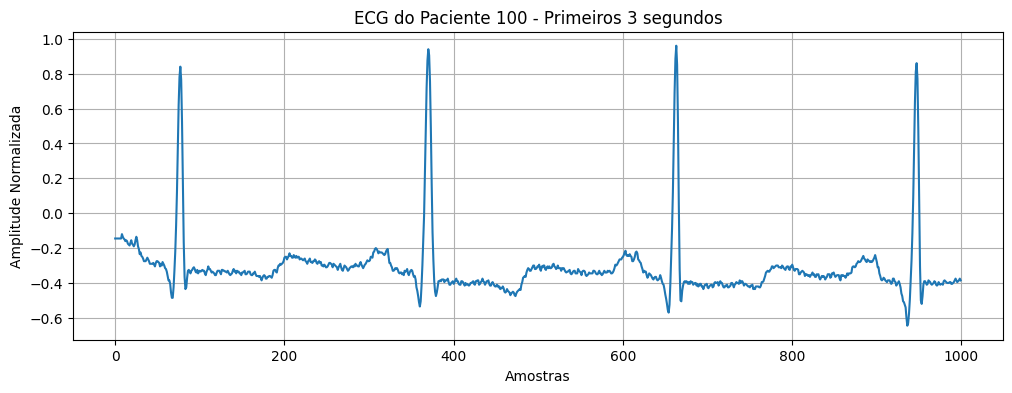

Tudo funcionando! Você já pode processar os dados.


In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Configura o tamanho da figura
plt.figure(figsize=(12, 4))

try:
    # Tenta ler o registro 100 (um paciente comum da base)
    # O caminho agora é direto na pasta 'mit-bih-data'
    record = wfdb.rdsamp('mit-bih-data/100')
    signal = record[0]

    # Plota os primeiros 1000 pontos (aprox. 3 segundos) do canal 0 (MLII)
    plt.plot(signal[:1000, 0])
    plt.title("ECG do Paciente 100 - Primeiros 3 segundos")
    plt.xlabel("Amostras")
    plt.ylabel("Amplitude Normalizada")
    plt.grid(True)
    plt.show()

    print("Tudo funcionando! Você já pode processar os dados.")

except Exception as e:
    print(f"Ainda houve um erro ao ler o arquivo: {e}")
    print("Verifique se a pasta 'mit-bih-data' contém arquivos .dat e .hea")

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Definir as Classes (Padrão AAMI para TCCs)
# Mapeia os códigos estranhos do MIT-BIH para 5 categorias simples
AAMI_CLASSES = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0, # Normal
    'A': 1, 'a': 1, 'J': 1, 'S': 1,         # S (Supraventricular)
    'V': 2, 'E': 2,                         # V (Ventricular)
    'F': 3,                                 # F (Fusão)
    '/': 4, 'f': 4, 'Q': 4                  # Q (Desconhecido/Paced)
}

# Lista de pacientes que vamos usar (alguns são ignorados por qualidade ruim na literatura)
pacientes = [
    '100','101','102','103','104','105','106','107','108','109','111','112','113',
    '114','115','116','117','118','119','121','122','123','124','200','201','202',
    '203','205','207','208','209','210','212','213','214','215','217','219','220',
    '221','222','223','228','230','231','232','233','234'
]

X_all = []
y_all = []

window_size = 180 # Vamos pegar 180 amostras antes e 180 depois do pico (Total 360)

print("Iniciando segmentação dos batimentos...")

for pt in pacientes:
    try:

        record = wfdb.rdsamp(f'mit-bih-data/{pt}')
        annotation = wfdb.rdann(f'mit-bih-data/{pt}', 'atr')

        # Pegar canal 0 (MLII) que é o mais comum
        signal = record[0][:, 0]

        # Normalizar o sinal do paciente entre 0 e 1 (Ajuda muito a CNN!)
        scaler = MinMaxScaler()
        signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

        # Ler os picos e símbolos
        peaks = annotation.sample
        symbols = annotation.symbol

        for i, symbol in enumerate(symbols):
            # Se o símbolo estiver no nosso mapa AAMI
            if symbol in AAMI_CLASSES:
                center = peaks[i]

                # Verifica se tem espaço suficiente antes e depois para cortar
                if center > window_size and center < (len(signal) - window_size):

                    # CORTA O BATIMENTO (Slice)
                    beat = signal[center - window_size : center + window_size]

                    # Salva na lista
                    X_all.append(beat)
                    y_all.append(AAMI_CLASSES[symbol])

    except Exception as e:
        print(f"Erro no paciente {pt}: {e}")


X = np.array(X_all)
y = np.array(y_all)

X = X[..., np.newaxis]

print("-" * 30)
print("Segmentação Concluída!")
print(f"Formato de X (Dados): {X.shape}")
print(f"Formato de y (Classes): {y.shape}")

Iniciando segmentação dos batimentos...
------------------------------
Segmentação Concluída!
Formato de X (Dados): (109437, 360, 1)
Formato de y (Classes): (109437,)


Distribuição das Classes: {np.int64(0): np.int64(90581), np.int64(1): np.int64(2781), np.int64(2): np.int64(7235), np.int64(3): np.int64(802), np.int64(4): np.int64(8038)}


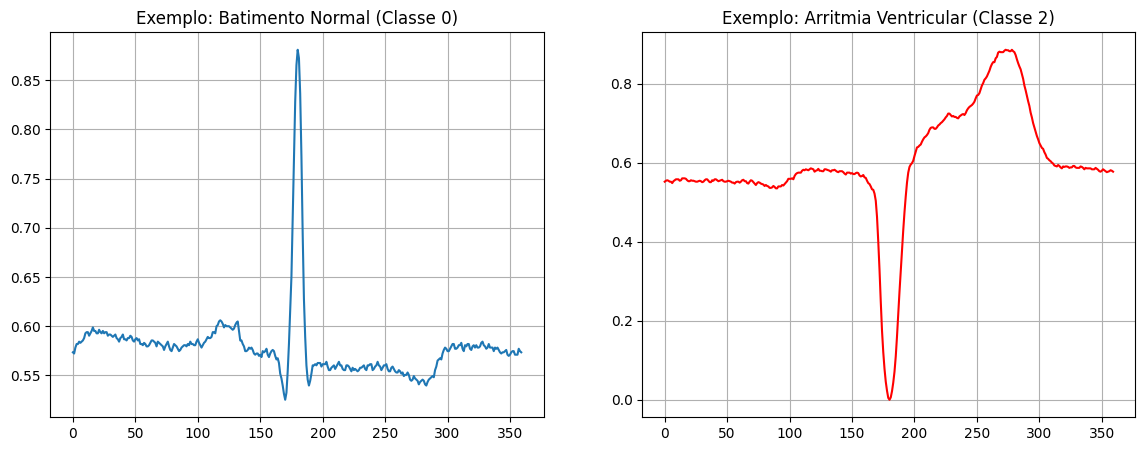

In [ ]:
# Contar quantos temos de cada classe
unique, counts = np.unique(y, return_counts=True)
print("Distribuição das Classes:", dict(zip(unique, counts)))
# 0: Normal, 1: S, 2: V, 3: F, 4: Q

# Plotar exemplos
plt.figure(figsize=(14, 5))

# Exemplo de Normal (Classe 0)
idx_normal = np.where(y == 0)[0][0]
plt.subplot(1, 2, 1)
plt.plot(X[idx_normal])
plt.title("Exemplo: Batimento Normal (Classe 0)")
plt.grid(True)

# Exemplo de Arritmia Ventricular (Classe 2 - Perigosa)
# Usamos 'try' caso não tenha encontrado nenhum (raro)
try:
    idx_v = np.where(y == 2)[0][0]
    plt.subplot(1, 2, 2)
    plt.plot(X[idx_v], color='red')
    plt.title("Exemplo: Arritmia Ventricular (Classe 2)")
    plt.grid(True)
except:
    print("Não achou exemplo da classe 2 para plotar.")

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

# 1. Dividir em Treino (80%) e Teste (20%)
# 'stratify=y' garante que a proporção de doenças seja a mesma no treino e no teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. One-Hot Encoding (Transforma '2' em '[0, 0, 1, 0, 0]')
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# 3. Calcular Pesos das Classes (Para resolver o desbalanceamento)
classes_unicas = np.unique(y_train)
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_unicas,
    y=y_train
)
class_weights = dict(enumerate(pesos))

print(f"Dados de Treino: {X_train.shape}")
print(f"Dados de Teste: {X_test.shape}")
print("Pesos calculados para equilibrar o treino:", class_weights)

Dados de Treino: (87549, 360, 1)
Dados de Teste: (21888, 360, 1)
Pesos calculados para equilibrar o treino: {0: np.float64(0.24163446676970635), 1: np.float64(7.869573033707865), 2: np.float64(3.02519004837595), 3: np.float64(27.273831775700934), 4: np.float64(2.7231415241057544)}


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- ARQUITETURA DA CNN ---
model = Sequential([
    # Camada 1: Extração de características básicas
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(), # Ajuda a rede a aprender mais rápido e estável
    MaxPooling1D(pool_size=2), # Reduz o tamanho do sinal pela metade

    # Camada 2: Extração de características mais complexas
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Camada 3
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Achatamento (Prepara para a classificação)
    Flatten(),

    # Classificador (Rede Densa)
    Dense(128, activation='relu'),
    Dropout(0.5), # Desliga 50% dos neurônios aleatoriamente para evitar decorar (overfitting)

    # Saída (5 neurônios, um para cada classe)
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- TREINAMENTO ---

# Callbacks: Parar se não melhorar e Salvar o melhor modelo
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True), # Para se não melhorar em 5 épocas
    ModelCheckpoint('melhor_modelo_ecg.keras', save_best_only=True) # Salva o campeão
]

print("Iniciando treinamento... (Isso vai levar alguns minutos)")
history = model.fit(
    X_train, y_train_cat,
    epochs=20, # Tenta treinar até 20 vezes
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights, # AQUI ESTÁ O SEGREDO DO BALANCEAMENTO!
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iniciando treinamento... (Isso vai levar alguns minutos)
Epoch 1/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 179s 128ms/step - accuracy: 0.6522 - loss: 1.1463 - val_accuracy: 0.8527 - val_loss: 0.5555
Epoch 2/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 169s 124ms/step - accuracy: 0.8374 - loss: 0.3998 - val_accuracy: 0.7933 - val_loss: 0.7819
Epoch 3/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 204s 125ms/step - accuracy: 0.8631 - loss: 0.3551 - val_accuracy: 0.8674 - val_loss: 0.5051
Epoch 4/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 171s 125ms/step - accuracy: 0.8790 - loss: 0.3170 - val_accuracy: 0.9345 - val_loss: 0.2462
Epoch 5/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 172s 126ms/step - accuracy: 0.8909 - loss: 0.3122 - val_accuracy: 0.9408 - val_loss: 0.3797
Epoch 6/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 221s 140ms/step - accuracy: 0.9040 - loss: 0.2592 - val_accuracy: 0.5748 - val_loss: 0.9378
Epoch 7/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 168s 123ms/step - accuracy: 0.9049 - loss: 0.2300 - val_accuracy: 0.9609 - val_loss: 0.2032
Epoch

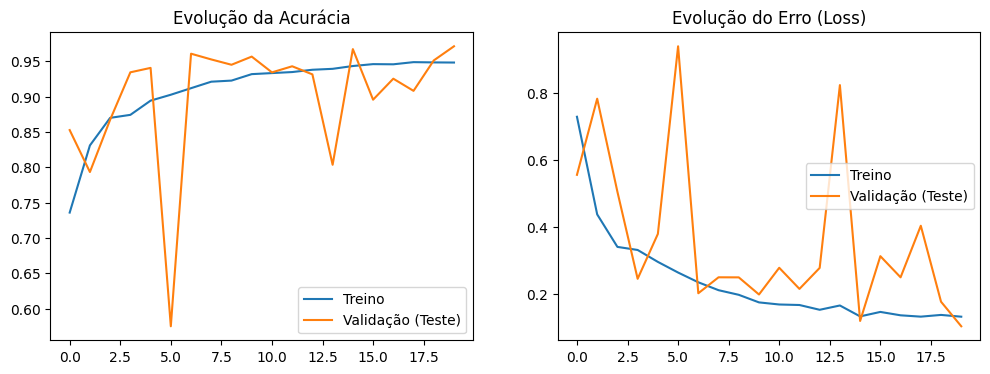

684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     18117
           S       0.62      0.95      0.75       556
           V       0.95      0.97      0.96      1447
           F       0.43      0.88      0.58       160
           Q       1.00      0.99      1.00      1608

    accuracy                           0.97     21888
   macro avg       0.80      0.95      0.85     21888
weighted avg       0.98      0.97      0.97     21888



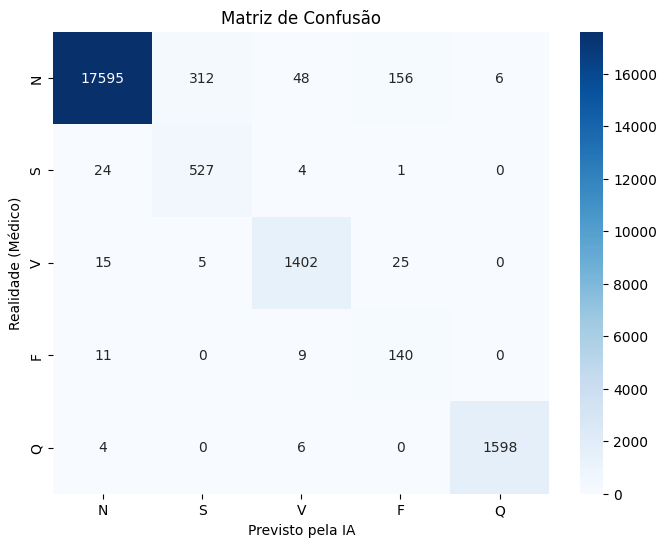

In [10]:
# Plotar Acurácia e Perda
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação (Teste)')
plt.title('Evolução da Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação (Teste)')
plt.title('Evolução do Erro (Loss)')
plt.legend()

plt.show()

# Matriz de Confusão (O teste final de fogo)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Fazer previsões no teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Relatório completo
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'S', 'V', 'F', 'Q']))

# Gráfico da Matriz
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'S', 'V', 'F', 'Q'], yticklabels=['N', 'S', 'V', 'F', 'Q'])
plt.xlabel('Previsto pela IA')
plt.ylabel('Realidade (Médico)')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
# Salvar o modelo no formato moderno do Keras (.keras)
model.save('modelo_ecg_final.keras')

print("Modelo salvo com sucesso!")

# Se você estiver usando o Google Colab, faça o download para o seu PC agora:
from google.colab import files
files.download('modelo_ecg_final.keras')

Modelo salvo com sucesso!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import os

# 1. Função para gerar dados de calibração (Representative Dataset)
# Isso é OBRIGATÓRIO para a quantização funcionar bem.
# Ele pega 100 amostras aleatórias do treino para "ensinar" o conversor
# qual o intervalo (range) dos números.
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        # O modelo espera float32
        yield [tf.cast(input_value, tf.float32)]

print("Iniciando a conversão para TFLite...")

# --- MODELO 1: Padrão (Sem otimização agressiva) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salvar Modelo 1
with open('model_padrao.tflite', 'wb') as f:
    f.write(tflite_model)
print("Modelo Padrão salvo: 'model_padrao.tflite'")

# --- MODELO 2: Otimizado (Quantização Int8) ---
converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)
converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
converter_opt.representative_dataset = representative_data_gen
# Garante que as operações sejam compatíveis com dispositivos Edge (CPU pura)
converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Define entrada e saída como int8 (opcional, mas bom para microcontroladores)
converter_opt.inference_input_type = tf.int8
converter_opt.inference_output_type = tf.int8

tflite_model_quant = converter_opt.convert()

# Salvar Modelo 2
with open('model_quantizado.tflite', 'wb') as f:
    f.write(tflite_model_quant)
print("Modelo Quantizado salvo: 'model_quantizado.tflite'")

# --- COMPARAÇÃO DE TAMANHO (Métrica para o TCC) ---
size_orig = os.path.getsize('model_padrao.tflite') / 1024
size_quant = os.path.getsize('model_quantizado.tflite') / 1024

print("-" * 30)
print(f"Tamanho Original (Float32): {size_orig:.2f} KB")
print(f"Tamanho Otimizado (Int8):   {size_quant:.2f} KB")
print(f"Redução de Tamanho:         {(1 - size_quant/size_orig)*100:.1f}%")
print("-" * 30)

Iniciando a conversão para TFLite...
Saved artifact at '/tmp/tmpofbxcf_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137601257526032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129688720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129689296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129686800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129686608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129685456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129688528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129689104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129690640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137599129690832: TensorSpec(shape=(), dtype=tf.resou

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Modelo Quantizado salvo: 'model_quantizado.tflite'
------------------------------
Tamanho Original (Float32): 2839.61 KB
Tamanho Otimizado (Int8):   727.80 KB
Redução de Tamanho:         74.4%
------------------------------


In [ ]:
from google.colab import files

# Baixar a versão otimizada (que vamos usar no App)
files.download('model_quantizado.tflite')

# Sugiro baixar a versão padrão também para ter de backup
files.download('model_padrao.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# 1. Vamos caçar um batimento Normal e um Perigoso nos seus dados de teste
# Lembra das classes? 0=Normal, 2=Ventricular (Perigo)

# Pega índices onde temos a classe 0 (Normal)
idx_normal = np.where(y_test == 0)[0][0:10] # Pega os 10 primeiros normais

# Pega índices onde temos a classe 2 (Ventricular)
idx_perigo = np.where(y_test == 2)[0][0:10] # Pega os 10 primeiros perigosos

print(f"Indices Normais: {idx_normal}")
print(f"Indices Perigo: {idx_perigo}")

# 2. Vamos criar uma "História" para o simulador
# O paciente está bem... bem... bem... e de repente: ATAQUE!
sequencia_simulada = []

# Adiciona 5 batimentos normais
for i in range(5):
    batimento = X_test[idx_normal[i]].flatten() # Transforma em lista 1D
    sequencia_simulada.extend(batimento)

# Adiciona 5 batimentos perigosos (Arritmia)
for i in range(5):
    batimento = X_test[idx_perigo[i]].flatten()
    sequencia_simulada.extend(batimento)

# Adiciona mais 5 normais (Recuperação)
for i in range(5):
    batimento = X_test[idx_normal[i+5]].flatten()
    sequencia_simulada.extend(batimento)

# 3. Salvar em arquivo .txt
# Vamos salvar como uma lista de números separados por quebra de linha
# Isso é super fácil de ler no Android/Kotlin depois.
nome_arquivo = "dados_ecg_simulados.txt"

with open(nome_arquivo, "w") as f:
    for valor in sequencia_simulada:
        f.write(f"{valor}\n")

print("-" * 30)
print(f"Arquivo '{nome_arquivo}' criado com sucesso!")
print(f"Total de pontos de sinal: {len(sequencia_simulada)}")
print("Baixe este arquivo agora, vamos colocá-lo dentro do celular virtual.")

# Baixar
from google.colab import files
files.download(nome_arquivo)

Indices Normais: [ 2  3  4  5  6  7  8  9 10 11]
Indices Perigo: [  0  31  46  71  88 104 114 123 171 180]
------------------------------
Arquivo 'dados_ecg_simulados.txt' criado com sucesso!
Total de pontos de sinal: 5400
Baixe este arquivo agora, vamos colocá-lo dentro do celular virtual.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>